In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

%matplotlib inline

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [4]:
train = pd.read_csv("../data/Avito Demand Prediction/train.csv", parse_dates = ["activation_date"])
test = pd.read_csv("../data/Avito Demand Prediction/test.csv", parse_dates = ["activation_date"])

In [12]:
train.shape, test.shape

((1503424, 18), (508438, 17))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null datetime64[ns]
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
dtypes: datetim

In [7]:
test.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,На ангарском,NaN,66,2017-04-18,Private,a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386...,2020.0
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,"Продам велосипед KAMA F200,в нормальном состо...",3000.0,4,2017-04-16,Private,NaN,NaN
2,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,Продам новый телевизор BBK 32 диагональ смарт...,15000.0,15,2017-04-17,Private,8c361112cb049745ef2d1b0ae73594fc5c107286b0c942...,2960.0
3,8e348601fefc,5f1d5c3ce0da,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,NaN,Вытяжка Jetair 60,"Продам новую вытяжку в упаковке,с документами....",4500.0,70,2017-04-17,Private,NaN,NaN
4,8bd2fe400b89,23e2d97bfc7f,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,Коляска зима-лето,Продам отличную коляску. б/у 1 год. все вопрос...,4900.0,15,2017-04-15,Private,bc3cf6deef10840fc302e38eb48fa7748aa1e28d534f8f...,1002.0


In [8]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [11]:
len(train['category_name'].value_counts()), len(test['category_name'].value_counts())

(47, 47)

In [10]:
train.describe()

,price,item_seq_number,image_top_1,deal_probability
count,1.418062e+06,1.503424e+06,1.390836e+06,1.503424e+06
mean,3.167081e+05,7.436740e+02,1.241932e+03,1.391306e-01
std,6.689154e+07,5.572522e+03,9.704641e+02,2.600785e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+02,9.000000e+00,4.250000e+02,0.000000e+00
50%,1.300000e+03,2.900000e+01,1.057000e+03,0.000000e+00
75%,7.000000e+03,8.800000e+01,2.217000e+03,1.508700e-01
max,7.950101e+10,2.044290e+05,3.066000e+03,1.000000e+00


**item_id** - Ad id.

**user_id** - User id.

**region** - Ad region.

**city** - Ad city.

**parent_category_name** - Top level ad category as classified by Avito's ad model.

**category_name** - Fine grain ad category as classified by Avito's ad model.

**param_1** - Optional parameter from Avito's ad model.

**param_2** - Optional parameter from Avito's ad model.

**param_3** - Optional parameter from Avito's ad model.

**title** - Ad title.

**description** - Ad description.

**price** - Ad price.

**item_seq_number** - Ad sequential number for user.

**activation_date**- Date ad was placed.

**user_type** - User type.

**image** - Id code of image. Ties to a jpg file in train_jpg. Not every ad has an image.

**image_top_1** - Avito's classification code for the image.

**deal_probability** - The target variable. This is the likelihood that an ad actually sold something. It's not possible to verify every transaction with certainty, so this column's value can be any float from zero to one.

## Пропущенные значения

In [11]:
null_value_stats = train.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

param_1         61576
param_2        654542
param_3        862565
description    116276
price           85362
image          112588
image_top_1    112588
dtype: int64

In [12]:
train["param_1"].fillna("", inplace=True)
train["param_2"].fillna("", inplace=True)
train["param_3"].fillna("", inplace=True)
train["description"].fillna("", inplace=True)
train["price"].fillna(-999, inplace=True)
train["image"].fillna("", inplace=True)
train["image_top_1"].fillna(-999, inplace=True)

In [13]:
null_value_stats = test.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

param_1         22910
param_2        233229
param_3        306331
price           30585
image           42609
image_top_1     42609
dtype: int64

In [14]:
test["param_1"].fillna("", inplace=True)
test["param_2"].fillna("", inplace=True)
test["param_3"].fillna("", inplace=True)
test["price"].fillna(-999, inplace=True)
test["image"].fillna("", inplace=True)
test["image_top_1"].fillna(-999, inplace=True)

## Feature Engineering

In [15]:
train['text'] = train[['title', 'description', 'param_1', 'param_2', 'param_3']].apply(lambda x: ' '.join(x), axis=1)
test['text'] = test[['title', 'description', 'param_1', 'param_2', 'param_3']].apply(lambda x: ' '.join(x), axis=1)

train["weekday"] = train["activation_date"].dt.weekday
test["weekday"] = test["activation_date"].dt.weekday

train["is_weekend"] = train['activation_date'].dt.weekday.apply(lambda x: 1 if x == 5 or x == 6 else 0)
test["is_weekend"] = test['activation_date'].dt.weekday.apply(lambda x: 1 if x == 5 or x == 6 else 0)

train["month"] = train["activation_date"].dt.month
test["month"] = test["activation_date"].dt.month

train["day"] = train["activation_date"].dt.day
test["day"] = test["activation_date"].dt.day

train["has_image"] = train['image'].apply(lambda x: 0 if x == '' else 1)
test["has_image"] = test['image'].apply(lambda x: 0 if x == '' else 1)

train["has_description"] = train['description'].apply(lambda x: 0 if x == '' else 1)
test["has_description"] = test['description'].apply(lambda x: 0 if x == '' else 1)

train["description_len"] = train['description'].apply(lambda x: len(x))
test["description_len"] = test['description'].apply(lambda x: len(x))

train["title_len"] = train['title'].apply(lambda x: len(x))
test["title_len"] = test['title'].apply(lambda x: len(x))

train["has_param_1"] = train['param_1'].apply(lambda x: 0 if x == '' else 1)
test["has_param_1"] = test['param_1'].apply(lambda x: 0 if x == '' else 1)

train["has_param_2"] = train['param_2'].apply(lambda x: 0 if x == '' else 1)
test["has_param_2"] = test['param_2'].apply(lambda x: 0 if x == '' else 1)

train["has_param_3"] = train['param_3'].apply(lambda x: 0 if x == '' else 1)
test["has_param_3"] = test['param_3'].apply(lambda x: 0 if x == '' else 1)

train["has_price"] = train['price'].apply(lambda x: 0 if x == -999 else 1)
test["has_price"] = test['price'].apply(lambda x: 0 if x == -999 else 1)

train["has_image_top_1"] = train['image_top_1'].apply(lambda x: 0 if x == -999 else 1)
test["has_image_top_1"] = test['image_top_1'].apply(lambda x: 0 if x == -999 else 1)

In [16]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,day,has_image,has_description,description_len,title_len,has_param_1,has_param_2,has_param_3,has_price,has_image_top_1
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,,,Кокоби(кокон для сна),...,28,1,1,58,21,1,0,0,1,1
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,,,Стойка для Одежды,...,26,1,1,41,17,1,0,0,1,1
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",,,Philips bluray,...,20,1,1,99,14,1,0,0,1,1
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,,,Автокресло,...,25,1,1,22,10,1,0,0,1,1
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,16,1,1,24,14,1,1,1,1,1


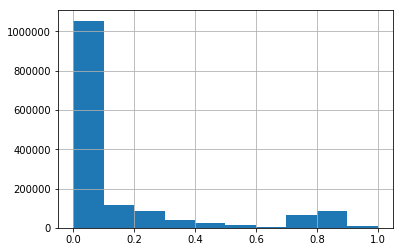

In [22]:
train['deal_probability'].hist();

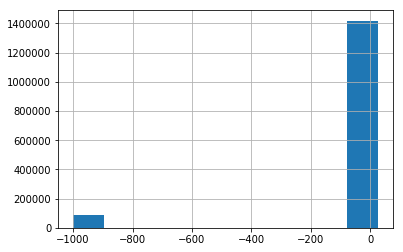

In [17]:
train['price'] = train['price'].apply(lambda x: np.log1p(x) if x != -999 else x)
train['price'].hist();

In [21]:
# sns.boxplot(train['price']); # Ящик с усами: середина это медиана, границы ящика это 0.25- и 0.75-квартили,усы - это полтора интеркваритильных размаха от медианы. То, что за усами - это выбросы 

In [22]:
# sns.countplot(train['region']);

In [23]:
# sns.countplot(train['category_name']);

In [24]:
# sns.countplot(train['user_type']);

In [25]:
# sns.countplot(train['city']);

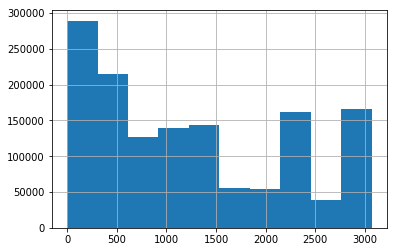

In [23]:
 train['image_top_1'].hist();

In [18]:
null_value_stats = train.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

## Change categorial features to numeric

In [17]:
categorical_features_indices = [
 'user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'param_1',
 'param_2',
 'param_3',
 'user_type']

categorical_features_indices

['user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'param_1',
 'param_2',
 'param_3',
 'user_type']

Различные значения категориальных признаков:

In [21]:
for col in categorical_features_indices:
    print(col + ": ", len(train[col].value_counts()))

user_id:  771769
region:  28
city:  1733
parent_category_name:  9
category_name:  47
param_1:  371
param_2:  271
param_3:  1219
user_type:  3


## Mean target encoding

In [22]:
skf = KFold(n_splits=5, shuffle=True, random_state=1)

# train_df, y = df.copy(), df['y']
# train_df_part, valid_df, y_train_part, y_valid = train_test_split(train_df.drop('y', axis=1), y, 
#                                                                   test_size=.3, stratify=y, 
#                                                                                random_state=17)

X = train.drop(['image', 'activation_date', 'deal_probability', 'item_id', 'title', 'description', 'text'], axis=1)
y = train['deal_probability']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=.3, random_state=17)

X_test = test.drop(['image', 'activation_date', 'item_id', 'title', 'description', 'text'], axis=1)

In [23]:
def mean_target_enc(train_df, y_train, valid_df, cat_features, skf):
    import warnings
    warnings.filterwarnings('ignore')
    
    glob_mean = y_train.mean()
    train_df = pd.concat([train_df, pd.Series(y_train, name='y')], axis=1)
    new_train_df = train_df.copy()
    
    # заполняем все глобальным средним
    for col in cat_features:
        new_train_df[col + '_mean_target'] = [glob_mean for _ in range(new_train_df.shape[0])]

    for train_idx, valid_idx in skf.split(train_df, y_train):
        train_df_cv, valid_df_cv = train_df.iloc[train_idx, :], train_df.iloc[valid_idx, :]

        for col in cat_features:
            
            means = valid_df_cv[col].map(train_df_cv.groupby(col)['y'].mean())
            valid_df_cv[col + '_mean_target'] = means.fillna(glob_mean)
            
        new_train_df.iloc[valid_idx] = valid_df_cv
    
    new_train_df.drop(cat_features + ['y'], axis=1, inplace=True)
    
    for col in cat_features:
        means = valid_df[col].map(train_df.groupby(col)['y'].mean())
        valid_df[col + '_mean_target'] = means.fillna(glob_mean)
        
    valid_df.drop(cat_features, axis=1, inplace=True)

    
    return new_train_df, valid_df

In [24]:
train_mean_target_part, valid_mean_target = mean_target_enc(X_train, y_train, X_validation, categorical_features_indices,skf)

In [25]:
train_mean_target_part.shape, valid_mean_target.shape

((1052396, 25), (451028, 25))

In [42]:
train_mean_target_part.columns

Index(['price', 'image_top_1', 'weekday', 'is_weekend', 'month', 'day',
       'has_image', 'has_description', 'description_len', 'title_len',
       'has_param_1', 'has_param_2', 'has_param_3', 'has_price',
       'has_image_top_1', 'user_id_mean_target', 'region_mean_target',
       'city_mean_target', 'parent_category_name_mean_target',
       'category_name_mean_target', 'param_1_mean_target',
       'param_2_mean_target', 'param_3_mean_target',
       'item_seq_number_mean_target', 'user_type_mean_target'],
      dtype='object')

In [26]:
# train_mean_target_part.to_csv('train_mean_target.csv')
# valid_mean_target.to_csv('valid_mean_target.csv')

## Tune XGBoost

In [70]:
from sklearn.model_selection import RandomizedSearchCV

gbm = xgb.XGBRegressor(n_estimators=500, learning_rate=0.005, gamma=1, subsample=0.8,
                       max_depth=14, reg_lambda=0.5, reg_alpha=0.3,
                           colsample_bytree=0.8, n_jobs=-1, nthread = 8, 
                       objective='reg:logistic', eval_metric='rmse', seed=42)



In [71]:
gbm.fit(train_mean_target_part, y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(valid_mean_target, y_validation)])

[0]	validation_0-rmse:0.443195
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.441572
[2]	validation_0-rmse:0.439956
[3]	validation_0-rmse:0.438354
[4]	validation_0-rmse:0.436752
[5]	validation_0-rmse:0.435162
[6]	validation_0-rmse:0.433606
[7]	validation_0-rmse:0.432032
[8]	validation_0-rmse:0.430473
[9]	validation_0-rmse:0.428947
[10]	validation_0-rmse:0.427406
[11]	validation_0-rmse:0.425875
[12]	validation_0-rmse:0.424352
[13]	validation_0-rmse:0.422847
[14]	validation_0-rmse:0.421352
[15]	validation_0-rmse:0.419879
[16]	validation_0-rmse:0.418394
[17]	validation_0-rmse:0.416916
[18]	validation_0-rmse:0.415458
[19]	validation_0-rmse:0.414018
[20]	validation_0-rmse:0.41257
[21]	validation_0-rmse:0.411142
[22]	validation_0-rmse:0.409725
[23]	validation_0-rmse:0.408311
[24]	validation_0-rmse:0.406903
[25]	validation_0-rmse:0.405511
[26]	validation_0-rmse:0.404117
[27]	validation_0-rmse:0.402747
[28]	validation_0-rmse:0.401386
[29]	validation_0-

[251]	validation_0-rmse:0.250504
[252]	validation_0-rmse:0.250265
[253]	validation_0-rmse:0.25003
[254]	validation_0-rmse:0.249788
[255]	validation_0-rmse:0.249551
[256]	validation_0-rmse:0.249317
[257]	validation_0-rmse:0.24909
[258]	validation_0-rmse:0.248858
[259]	validation_0-rmse:0.248628
[260]	validation_0-rmse:0.248399
[261]	validation_0-rmse:0.248173
[262]	validation_0-rmse:0.247959
[263]	validation_0-rmse:0.247738
[264]	validation_0-rmse:0.247518
[265]	validation_0-rmse:0.247302
[266]	validation_0-rmse:0.247088
[267]	validation_0-rmse:0.246876
[268]	validation_0-rmse:0.246664
[269]	validation_0-rmse:0.246458
[270]	validation_0-rmse:0.24625
[271]	validation_0-rmse:0.246049
[272]	validation_0-rmse:0.245844
[273]	validation_0-rmse:0.245647
[274]	validation_0-rmse:0.245449
[275]	validation_0-rmse:0.245249
[276]	validation_0-rmse:0.245056
[277]	validation_0-rmse:0.244863
[278]	validation_0-rmse:0.244672
[279]	validation_0-rmse:0.24448
[280]	validation_0-rmse:0.244296
[281]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='rmse', gamma=1,
       learning_rate=0.005, max_delta_step=0, max_depth=14,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
       nthread=8, objective='reg:logistic', random_state=0, reg_alpha=0.3,
       reg_lambda=0.5, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

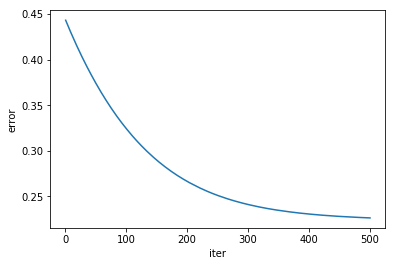

In [72]:
errors_by_iter = gbm.evals_result()['validation_0']['rmse']
plt.plot(range(1, len(errors_by_iter) + 1), errors_by_iter)
plt.xlabel('iter');
plt.ylabel('error');



In [64]:
                       
tree_params = {'max_depth': [7, 10, 14], 
               'gamma': [0, 0.3, 0.7, 1],
                'reg_alpha': [0, 0.3, 0.5],
                'reg_lambda': [0, 0.3, 0.5],
                'colsample_bytree': [0.6, 0.7, 0.8]}
tree_grid = RandomizedSearchCV(gbm, tree_params, n_jobs=-1, verbose=2, random_state=17)


In [65]:
%%time

fit_params = {'early_stopping_rounds': 10, 'eval_metric': "rmse",
        'eval_set': [(train_mean_target_part, y_train)]}

tree_grid.fit(valid_mean_target, y_validation, **fit_params);

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] reg_lambda=0.5, reg_alpha=0.3, max_depth=14, gamma=1, colsample_bytree=0.8 
[CV] reg_lambda=0.5, reg_alpha=0.3, max_depth=14, gamma=1, colsample_bytree=0.8 
[CV] reg_lambda=0.5, reg_alpha=0.3, max_depth=14, gamma=1, colsample_bytree=0.8 
[CV] reg_lambda=0.5, reg_alpha=0.3, max_depth=14, gamma=0.7, colsample_bytree=0.8 
[0]	validation_0-rmse:0.443186
Will train until validation_0-rmse hasn't improved in 10 rounds.
[CV] reg_lambda=0.5, reg_alpha=0.3, max_depth=14, gamma=0.7, colsample_bytree=0.8 
[CV] reg_lambda=0.5, reg_alpha=0.3, max_depth=14, gamma=0.7, colsample_bytree=0.8 
[0]	validation_0-rmse:0.443189
Will train until validation_0-rmse hasn't improved in 10 rounds.
[CV] reg_lambda=0.5, reg_alpha=0.5, max_depth=10, gamma=0, colsample_bytree=0.7 
[1]	validation_0-rmse:0.441576
[0]	validation_0-rmse:0.443197
Will train until validation_0-rmse hasn't improved in 10 rounds.
[0]	validation_0-rmse:0.443186
Will train until

[25]	validation_0-rmse:0.405777
[23]	validation_0-rmse:0.408571
[1]	validation_0-rmse:0.441602
[25]	validation_0-rmse:0.405798
[22]	validation_0-rmse:0.409985
[2]	validation_0-rmse:0.440008
[26]	validation_0-rmse:0.404401
[26]	validation_0-rmse:0.404407
[26]	validation_0-rmse:0.404396
[0]	validation_0-rmse:0.443196
Will train until validation_0-rmse hasn't improved in 10 rounds.
[24]	validation_0-rmse:0.407171
[26]	validation_0-rmse:0.404424
[3]	validation_0-rmse:0.43843
[23]	validation_0-rmse:0.408579
[27]	validation_0-rmse:0.403032
[27]	validation_0-rmse:0.403035
[27]	validation_0-rmse:0.403024
[1]	validation_0-rmse:0.4416
[25]	validation_0-rmse:0.405794
[4]	validation_0-rmse:0.436862
[27]	validation_0-rmse:0.403052
[24]	validation_0-rmse:0.407186
[28]	validation_0-rmse:0.401679
[28]	validation_0-rmse:0.401678
[5]	validation_0-rmse:0.435306
[28]	validation_0-rmse:0.401666
[2]	validation_0-rmse:0.440019
[26]	validation_0-rmse:0.404413
[6]	validation_0-rmse:0.433762
[28]	validation_0-r

[22]	validation_0-rmse:0.410308
[16]	validation_0-rmse:0.418675
[21]	validation_0-rmse:0.411735
[2]	validation_0-rmse:0.44003
[24]	validation_0-rmse:0.407298
[27]	validation_0-rmse:0.403411
[23]	validation_0-rmse:0.408913
[22]	validation_0-rmse:0.410325
[18]	validation_0-rmse:0.415812
[13]	validation_0-rmse:0.423075
[17]	validation_0-rmse:0.417222
[28]	validation_0-rmse:0.402054
[24]	validation_0-rmse:0.407516
[25]	validation_0-rmse:0.405917
[3]	validation_0-rmse:0.438432
[23]	validation_0-rmse:0.408922
[25]	validation_0-rmse:0.406131
[29]	validation_0-rmse:0.400715
[19]	validation_0-rmse:0.41439
[14]	validation_0-rmse:0.421626
[18]	validation_0-rmse:0.41577
[26]	validation_0-rmse:0.404543
[24]	validation_0-rmse:0.407528
[26]	validation_0-rmse:0.404766
[4]	validation_0-rmse:0.436858
[20]	validation_0-rmse:0.412981
[15]	validation_0-rmse:0.420147
[CV]  reg_lambda=0.3, reg_alpha=0.5, max_depth=10, gamma=0, colsample_bytree=0.6, total= 3.2min
[CV] reg_lambda=0.5, reg_alpha=0.5, max_depth=

[22]	validation_0-rmse:0.410295
[13]	validation_0-rmse:0.423121
[20]	validation_0-rmse:0.41315
[6]	validation_0-rmse:0.433751
[15]	validation_0-rmse:0.420205
[24]	validation_0-rmse:0.407297
[14]	validation_0-rmse:0.421653
[7]	validation_0-rmse:0.432216
[23]	validation_0-rmse:0.408907
[22]	validation_0-rmse:0.410296
[16]	validation_0-rmse:0.418745
[18]	validation_0-rmse:0.415807
[21]	validation_0-rmse:0.411728
[8]	validation_0-rmse:0.430678
[15]	validation_0-rmse:0.420183
[24]	validation_0-rmse:0.407509
[23]	validation_0-rmse:0.408902
[17]	validation_0-rmse:0.417308
[9]	validation_0-rmse:0.42916
[16]	validation_0-rmse:0.418722
[25]	validation_0-rmse:0.405918
[22]	validation_0-rmse:0.410318
[18]	validation_0-rmse:0.415866
[19]	validation_0-rmse:0.414385
[10]	validation_0-rmse:0.427641
[24]	validation_0-rmse:0.407503
[17]	validation_0-rmse:0.417285
[25]	validation_0-rmse:0.406135
[23]	validation_0-rmse:0.408914
[19]	validation_0-rmse:0.414449
[18]	validation_0-rmse:0.415843
[11]	validatio

[14]	validation_0-rmse:0.421686
[17]	validation_0-rmse:0.417305
[22]	validation_0-rmse:0.41029
[19]	validation_0-rmse:0.414538
[16]	validation_0-rmse:0.418743
[20]	validation_0-rmse:0.413076
[18]	validation_0-rmse:0.415855
[15]	validation_0-rmse:0.42021
[23]	validation_0-rmse:0.408902
[20]	validation_0-rmse:0.413139
[17]	validation_0-rmse:0.417299
[16]	validation_0-rmse:0.418753
[19]	validation_0-rmse:0.414429
[21]	validation_0-rmse:0.411659
[24]	validation_0-rmse:0.407504
[21]	validation_0-rmse:0.411718
[18]	validation_0-rmse:0.41585
[17]	validation_0-rmse:0.41731
[20]	validation_0-rmse:0.412999
[22]	validation_0-rmse:0.410286
[25]	validation_0-rmse:0.40613
[22]	validation_0-rmse:0.410307
[19]	validation_0-rmse:0.414422
[18]	validation_0-rmse:0.415864
[23]	validation_0-rmse:0.408892
[21]	validation_0-rmse:0.411569
[26]	validation_0-rmse:0.404761
[23]	validation_0-rmse:0.408904
[20]	validation_0-rmse:0.412992
[19]	validation_0-rmse:0.414443
[24]	validation_0-rmse:0.407493
[22]	validati

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.5min finished


[0]	validation_0-rmse:0.443192
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.441577
[2]	validation_0-rmse:0.439965
[3]	validation_0-rmse:0.438364
[4]	validation_0-rmse:0.436778
[5]	validation_0-rmse:0.435203
[6]	validation_0-rmse:0.433633
[7]	validation_0-rmse:0.432082
[8]	validation_0-rmse:0.430541
[9]	validation_0-rmse:0.429015
[10]	validation_0-rmse:0.427489
[11]	validation_0-rmse:0.425979
[12]	validation_0-rmse:0.424467
[13]	validation_0-rmse:0.422963
[14]	validation_0-rmse:0.421472
[15]	validation_0-rmse:0.419989
[16]	validation_0-rmse:0.418512
[17]	validation_0-rmse:0.417045
[18]	validation_0-rmse:0.415602
[19]	validation_0-rmse:0.414155
[20]	validation_0-rmse:0.412719
[21]	validation_0-rmse:0.411284
[22]	validation_0-rmse:0.409871
[23]	validation_0-rmse:0.408463
[24]	validation_0-rmse:0.407073
[25]	validation_0-rmse:0.405691
[26]	validation_0-rmse:0.404309
[27]	validation_0-rmse:0.402937
[28]	validation_0-rmse:0.401585
[29]	validation_0

In [66]:
tree_grid.best_params_

{'reg_lambda': 0.5,
 'reg_alpha': 0.3,
 'max_depth': 14,
 'gamma': 1,
 'colsample_bytree': 0.8}

In [99]:
gbm = xgb.XGBRegressor(n_estimators=100, learning_rate=0.01, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=10, silent=False, n_jobs=-1, 
                       nthread = 8, objective='reg:logistic', eval_metric='rmse', seed=42)


In [100]:
np.mean(cross_val_score(gbm, train_mean_target_part, y_train, cv=skf, scoring='neg_mean_squared_error'))

-0.05163997916773729

In [101]:
np.sqrt(-1*-0.07972302886454567)

0.2823526675357357

In [73]:
train_submission, test_submission = mean_target_enc(X, y, X_test, categorical_features_indices,skf)

In [74]:
train_submission.shape, y.shape

((1503424, 25), (1503424,))

In [75]:
gbm.fit(train_submission, y)
predictions = gbm.predict(test_submission)

In [76]:
gbm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='rmse', gamma=1,
       learning_rate=0.005, max_delta_step=0, max_depth=14,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
       nthread=8, objective='reg:logistic', random_state=0, reg_alpha=0.3,
       reg_lambda=0.5, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [77]:
submission = pd.DataFrame(columns=['item_id', 'deal_probability'])
submission['item_id'] = test['item_id']
submission['deal_probability'] = predictions
submission.head()



,item_id,deal_probability
0,6544e41a8817,0.133868
1,65b9484d670f,0.131444
2,8bab230b2ecd,0.166827
3,8e348601fefc,0.129712
4,8bd2fe400b89,0.195128


In [78]:
submission.to_csv('submission.csv', index=False)

In [39]:
for feature in log_progress(categorical_features_indices, every=1):
    mean_target_dict = train.groupby([feature])['deal_probability'].mean()
    train[feature] = train[feature].map(mean_target_dict)

A Jupyter Widget

In [40]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,day,has_image,has_description,description_len,title_len,has_param_1,has_param_2,has_param_3,has_price,has_image_top_1
0,b912c3c6a6ad,0.12789,0.122004,0.123397,0.075876,0.198445,0.090057,0.169737,0.174625,Кокоби(кокон для сна),...,28,1,1,58,21,1,0,0,1,1
1,2dac0150717d,0.00000,0.136721,0.139400,0.179633,0.191848,0.126030,0.169737,0.174625,Стойка для Одежды,...,26,1,1,41,17,1,0,0,1,1
2,ba83aefab5dc,0.33309,0.135944,0.124881,0.175421,0.171572,0.123831,0.169737,0.174625,Philips bluray,...,20,1,1,99,14,1,0,0,1,1
3,02996f1dd2ea,0.80323,0.142602,0.135031,0.075876,0.198445,0.333498,0.169737,0.174625,Автокресло,...,25,1,1,22,10,1,0,0,1,1
4,7c90be56d2ab,0.20797,0.145908,0.137275,0.263336,0.278427,0.283049,0.365193,0.373487,"ВАЗ 2110, 2003",...,16,1,1,24,14,1,1,1,1,1


In [27]:
le = LabelEncoder()

for feature in log_progress(categorical_features_indices, every=1):
    le.fit(train[feature].append(test[feature]))
    train[feature] = le.transform(train[feature])
    test[feature] = le.transform(test[feature])
    
le.classes_

array([0, 1])

In [28]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,day,has_image,has_description,description_len,title_len,has_param_1,has_param_2,has_param_3,has_price,has_image_top_1
0,b912c3c6a6ad,884270,19,462,4,42,249,0,0,Кокоби(кокон для сна),...,20,1,1,58,20,1,0,0,1,1
1,2dac0150717d,227908,17,1314,2,22,122,0,0,Стойка для Одежды,...,18,1,1,41,16,1,0,0,1,1
2,ba83aefab5dc,576261,16,1290,0,2,84,0,0,Philips bluray,...,12,1,1,99,13,1,0,0,1,1
3,02996f1dd2ea,755087,21,950,4,42,38,0,0,Автокресло,...,17,1,1,22,9,1,0,0,1,1
4,7c90be56d2ab,944363,4,318,6,0,278,124,47,"ВАЗ 2110, 2003",...,8,1,1,24,13,1,1,1,1,1


In [29]:
test.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,day,has_image,has_description,description_len,title_len,has_param_1,has_param_2,has_param_3,has_price,has_image_top_1
0,6544e41a8817,867817,4,318,4,10,110,198,75,Отдам бесплатно,...,10,1,1,12,14,1,1,1,0,1
1,65b9484d670f,181851,19,993,8,5,119,0,0,Продам велосипед,...,8,0,1,88,15,1,0,0,1,0
2,8bab230b2ecd,45341,12,151,0,2,318,0,0,BBK,...,9,1,1,132,2,1,0,0,1,1
3,8e348601fefc,375979,18,1319,2,4,108,131,0,Вытяжка Jetair 60,...,9,0,1,93,16,1,1,0,1,0
4,8bd2fe400b89,141497,14,243,4,42,102,0,0,Коляска зима-лето,...,7,1,1,60,16,1,0,0,1,1


In [30]:
train.columns


Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'image', 'image_top_1', 'deal_probability', 'text',
       'weekday', 'is_weekend', 'month', 'day', 'has_image', 'has_description',
       'description_len', 'title_len', 'has_param_1', 'has_param_2',
       'has_param_3', 'has_price', 'has_image_top_1'],
      dtype='object')

In [31]:
X = train.drop(['image', 'activation_date', 'deal_probability', 'item_id', 'title', 'description', 'text'], axis=1)
y = train['deal_probability']
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = test.drop(['image', 'activation_date', 'item_id', 'title', 'description', 'text'], axis=1)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [32]:
X_train_matrix = X_train.as_matrix()
X_test_matrix = X_validation.as_matrix()

In [33]:
gbm = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7, silent=False, n_jobs=-1, nthread = 8, objective='reg:logistic', eval_metric='rmse', seed=42)
#.fit(X_train_matrix, y_train)


In [34]:
gbm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.08,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=8, objective='reg:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=False, subsample=0.75)

In [35]:
from sklearn.model_selection import GridSearchCV

# tree_params = {'max_depth': np.arange(1,11), 'n_estimators': [0.5, 0.7, 1], gamma: []}
tree_params = {'max_depth': [7, 10], 'learning_rate': [0.3, 0.8], 'gamma': [0, 0.5, 1, 10]}

tree_grid = GridSearchCV(gbm, tree_params, cv=5, n_jobs=-1, verbose=2)

In [36]:
%%time
tree_grid.fit(X_train, y_train);

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] gamma=0, learning_rate=0.3, max_depth=7 .........................
[CV] gamma=0, learning_rate=0.3, max_depth=7 .........................
[CV] gamma=0, learning_rate=0.3, max_depth=7 .........................
[CV] gamma=0, learning_rate=0.3, max_depth=7 .........................
[CV] gamma=0, learning_rate=0.3, max_depth=7 .........................
[CV] gamma=0, learning_rate=0.3, max_depth=10 ........................
[CV] gamma=0, learning_rate=0.3, max_depth=10 ........................
[CV] gamma=0, learning_rate=0.3, max_depth=10 ........................
[CV] .......... gamma=0, learning_rate=0.3, max_depth=7, total=10.5min
[CV] gamma=0, learning_rate=0.3, max_depth=10 ........................
[CV] .......... gamma=0, learning_rate=0.3, max_depth=7, total=10.5min
[CV] gamma=0, learning_rate=0.3, max_depth=10 ........................
[CV] .......... gamma=0, learning_rate=0.3, max_depth=7, total=10.5min
[CV] gamma=0, le

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 49.4min


[CV] ....... gamma=0.5, learning_rate=0.3, max_depth=10, total=15.1min
[CV] gamma=0.5, learning_rate=0.8, max_depth=7 .......................
[CV] ....... gamma=0.5, learning_rate=0.3, max_depth=10, total=15.3min
[CV] gamma=0.5, learning_rate=0.8, max_depth=7 .......................
[CV] ....... gamma=0.5, learning_rate=0.3, max_depth=10, total=15.2min
[CV] gamma=0.5, learning_rate=0.8, max_depth=10 ......................
[CV] ........ gamma=0.5, learning_rate=0.8, max_depth=7, total= 9.6min
[CV] gamma=0.5, learning_rate=0.8, max_depth=10 ......................
[CV] ....... gamma=0.5, learning_rate=0.3, max_depth=10, total=15.2min
[CV] gamma=0.5, learning_rate=0.8, max_depth=10 ......................
[CV] ....... gamma=0.5, learning_rate=0.3, max_depth=10, total=15.3min
[CV] gamma=0.5, learning_rate=0.8, max_depth=10 ......................
[CV] ........ gamma=0.5, learning_rate=0.8, max_depth=7, total= 9.6min
[CV] gamma=0.5, learning_rate=0.8, max_depth=10 ......................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 125.0min finished


CPU times: user 15min 57s, sys: 13.2 s, total: 16min 10s
Wall time: 2h 6min 54s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.08,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=8, objective='reg:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=False, subsample=0.75),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [7, 10], 'learning_rate': [0.3, 0.8], 'gamma': [0, 0.5, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [37]:
tree_grid.best_score_, tree_grid.best_params_

(0.23682518885886547, {'gamma': 10, 'learning_rate': 0.3, 'max_depth': 10})

(0.23544268971637272, {'max_depth': 10, 'n_estimators': 100})

In [38]:
tree_params['max_depth'], tree_grid.cv_results_['mean_test_score']

([7, 10], array([0.23674686, 0.23455175, 0.2068249 , 0.11504001, 0.23633035,
        0.23432431, 0.20655919, 0.11854172, 0.23613334, 0.23440024,
        0.20617454, 0.12101886, 0.23130716, 0.23682519, 0.22774954,
        0.22859246]))

In [39]:
tree_grid.cv_results_

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args

{'mean_fit_time': array([626.39275694, 950.79872379, 638.0853354 , 972.71310925,
        633.00669403, 907.3197082 , 556.64789143, 803.29310551,
        493.63934112, 775.16668553, 526.39196296, 807.8754024 ,
        526.95129104, 811.77848072, 558.23585758, 662.28805032]),
 'std_fit_time': array([ 1.77556461,  6.09598561,  6.12135942,  5.06589228, 11.87139981,
         4.57375325, 15.44195955,  5.92629374, 23.71667489,  9.84734578,
         6.273921  ,  8.36397683, 14.83022371, 11.59495718,  8.08526779,
        40.70214588]),
 'mean_score_time': array([ 4.76545506,  9.74002647,  5.25723548, 10.61315813,  4.84760408,
         7.29897938,  4.59161158,  6.21260881,  5.87892437,  7.59099898,
         5.12981238,  8.68478727,  4.56162949,  5.38750129,  3.4788547 ,
         1.7620985 ]),
 'std_score_time': array([0.35639429, 1.18480267, 0.50092056, 1.06136746, 1.09296104,
        1.47058244, 1.41025722, 0.78572821, 0.30032432, 1.4515878 ,
        0.24938225, 1.40071869, 0.64264595, 0.302178

In [48]:
tree_grid.cv_results_['param_max_depth'].data

array([3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10,
       10, 10], dtype=object)

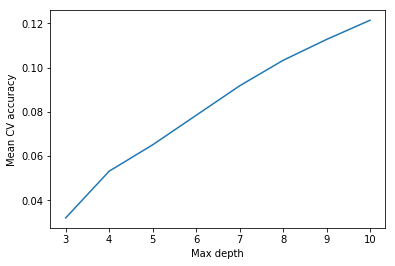

In [50]:
# scores = [tree_grid.cv_results_['mean_test_score'][0], 
#           tree_grid.cv_results_['mean_test_score'][3], 
#           tree_grid.cv_results_['mean_test_score'][6], 
#           tree_grid.cv_results_['mean_test_score'][9],
#           tree_grid.cv_results_['mean_test_score'][12],
#           tree_grid.cv_results_['mean_test_score'][15],
#           tree_grid.cv_results_['mean_test_score'][18],
#           tree_grid.cv_results_['mean_test_score'][21]]
# plt.plot(tree_params['max_depth'], 
#          scores)
# plt.xlabel('Max depth')
# plt.ylabel('Mean CV accuracy');

In [40]:
from sklearn.externals import joblib
joblib.dump(tree_grid.best_estimator_, 'tree_grid_best_xgboost.pkl', compress = 1)

['tree_grid_best_xgboost.pkl']

In [41]:
joblib.dump(tree_grid.cv_results_, 'tree_grid_cv_results.pkl', compress = 1)

['tree_grid_cv_results.pkl']

In [44]:
predictions = tree_grid.best_estimator_.predict(X_train)

In [45]:
from sklearn.metrics import mean_squared_error

In [46]:
np.sqrt(mean_squared_error(y_train, predictions))

0.22495553023133752

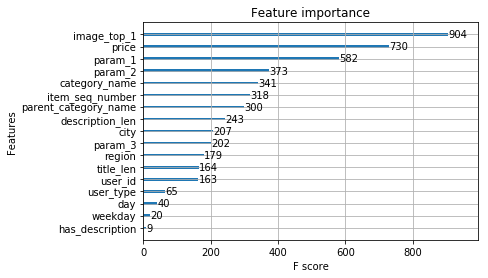

In [47]:
from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(tree_grid.best_estimator_)
pyplot.show()

## Submission

In [49]:
predictions = tree_grid.best_estimator_.predict(X_test)

In [51]:
submission = pd.DataFrame(columns=['item_id', 'deal_probability'])
submission['item_id'] = test['item_id']
submission['deal_probability'] = predictions
submission.head()

,item_id,deal_probability
0,6544e41a8817,0.107764
1,65b9484d670f,0.105769
2,8bab230b2ecd,0.108077
3,8e348601fefc,0.097238
4,8bd2fe400b89,0.211617


In [52]:
submission.to_csv('submission.csv', index=False)

In [157]:
X_train.columns

Index(['user_id', 'region', 'city', 'parent_category_name', 'category_name',
       'param_1', 'param_2', 'param_3', 'price', 'item_seq_number',
       'user_type', 'image_top_1', 'weekday', 'is_weekend', 'month', 'day',
       'has_image', 'has_description', 'description_len', 'title_len',
       'has_param_1', 'has_param_2', 'has_param_3', 'has_price',
       'has_image_top_1'],
      dtype='object')

In [ ]:
model.save_model('avito_catboost_model.dump')

In [ ]:
pred = model.predict(X_test, verbose=True)

In [ ]:
pred[:10]

In [ ]:
def normalize(x):
    return 0 if x < 0 else (1 if x > 1 else x)

pred2 = [normalize(x) for x in pred]

In [ ]:
pred2[:10]

In [ ]:
submission = pd.DataFrame(columns=['item_id', 'deal_probability'])

In [ ]:
submission['item_id'] = test['item_id']
submission['deal_probability'] = pred2

In [ ]:
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)